IMPORT LIBRARIES

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

DATASET

In [16]:
train_dataset_path ='Dataset/train'
validation_dataset_path ='Dataset/test'

LOAD DATASET

In [17]:
IMG_WIDTH = 182
IMG_HEIGHT = 256
BATCH_SIZE = 32


In [18]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 2609 images belonging to 5 classes.


LOAD VALIDATION DATASET

In [19]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 2609 images belonging to 5 classes.


LABEL MAPPING

In [20]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Acne
1 : Atopic Dermatitis
2 : Eczema Photos
3 : Seborrheic Keratoses
4 : Tinea Ringworm


SAMPLE TRAIN IMAGES

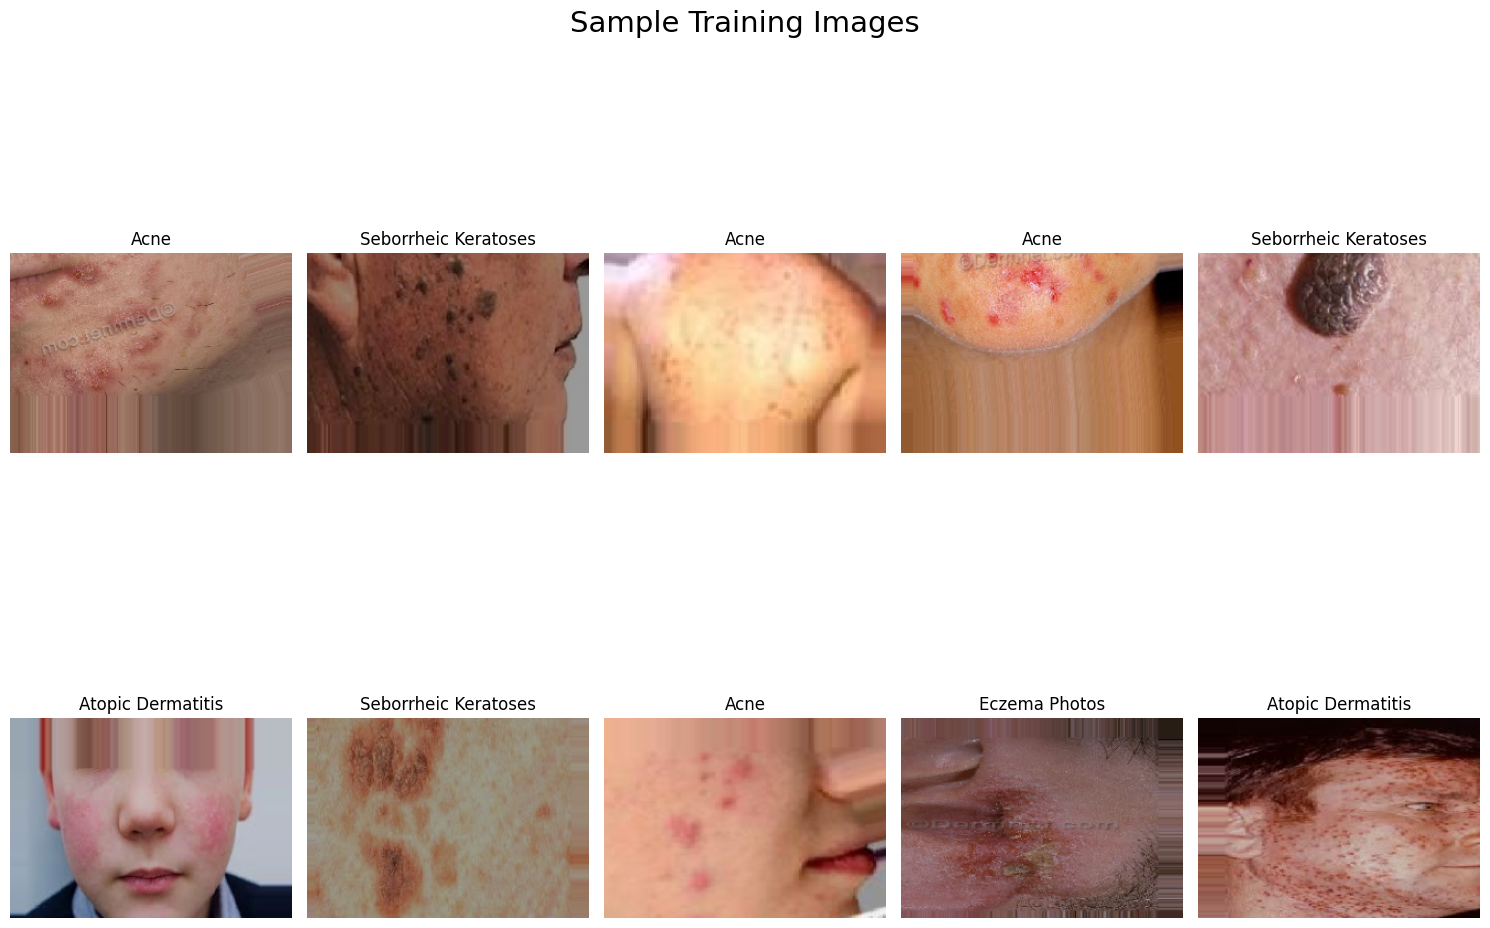

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

CNN

In [32]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=5, activation='softmax')
    ])
    
    return model

In [33]:
cnn_model = create_model()

MODEL SEQUENTIAL

In [34]:
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 252, 128)     9728      
                                                                 
 activation_6 (Activation)   (None, 178, 252, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 126, 128)      0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 89, 126, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 124, 64)       73792     
                                                                 
 activation_7 (Activation)   (None, 87, 124, 64)      

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [36]:
optimizer = Adam(learning_rate=0.001)

In [37]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

EPOCH

In [38]:
history = cnn_model.fit(train_generator, epochs=30, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/30
82/82 - 291s - loss: 10.3930 - accuracy: 0.3292 - val_loss: 3.9113 - val_accuracy: 0.3595 - lr: 0.0010 - 291s/epoch - 4s/step
Epoch 2/30
82/82 - 319s - loss: 7.0379 - accuracy: 0.3714 - val_loss: 5.6053 - val_accuracy: 0.1594 - lr: 0.0010 - 319s/epoch - 4s/step
Epoch 3/30
82/82 - 291s - loss: 4.0878 - accuracy: 0.3959 - val_loss: 1.8164 - val_accuracy: 0.4071 - lr: 0.0010 - 291s/epoch - 4s/step
Epoch 4/30
82/82 - 289s - loss: 2.6252 - accuracy: 0.4323 - val_loss: 2.5003 - val_accuracy: 0.3388 - lr: 0.0010 - 289s/epoch - 4s/step
Epoch 5/30
82/82 - 1051s - loss: 1.9331 - accuracy: 0.4573 - val_loss: 2.1512 - val_accuracy: 0.2871 - lr: 0.0010 - 1051s/epoch - 13s/step
Epoch 6/30
82/82 - 297s - loss: 1.6158 - accuracy: 0.4868 - val_loss: 5.9150 - val_accuracy: 0.2154 - lr: 0.0010 - 297s/epoch - 4s/step
Epoch 7/30
82/82 - 296s - loss: 1.5282 - accuracy: 0.4906 - val_loss: 2.3173 - val_accuracy: 0.4327 - lr: 0.0010 - 296s/epoch - 4s/step
Epoch 8/30
82/82 - 299s - loss: 1.3578 - acc

MODEL METRICES

In [39]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

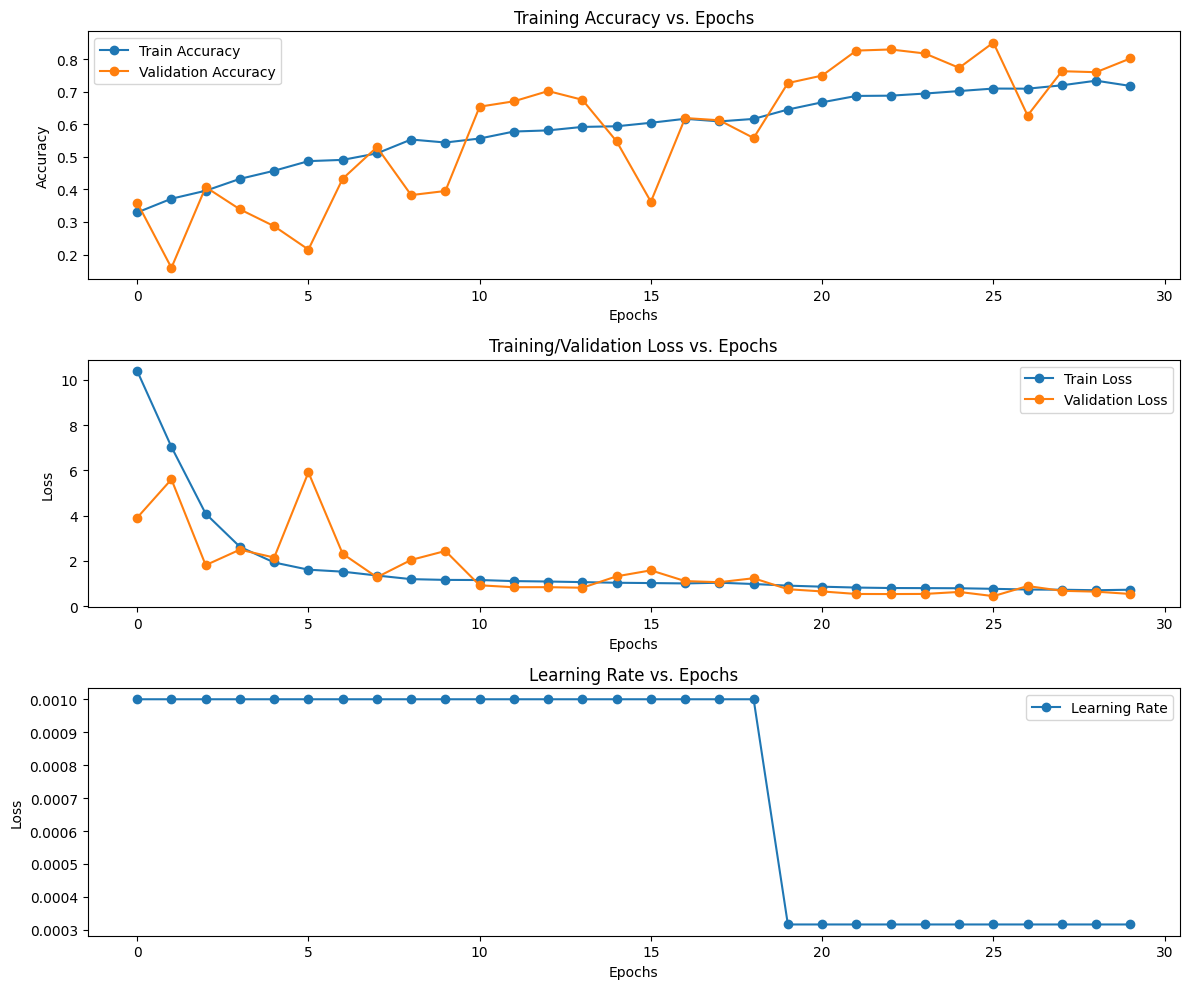

In [40]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

TEST MODEL

In [41]:
test_dataset = 'Dataset/test'

In [42]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 2609 images belonging to 5 classes.


MODEL PREDICTIONS

In [43]:
predictions = cnn_model.predict(test_generator)

82/82 [==============================] - 58s 698ms/step


TEST DATASET PREDICTIONS

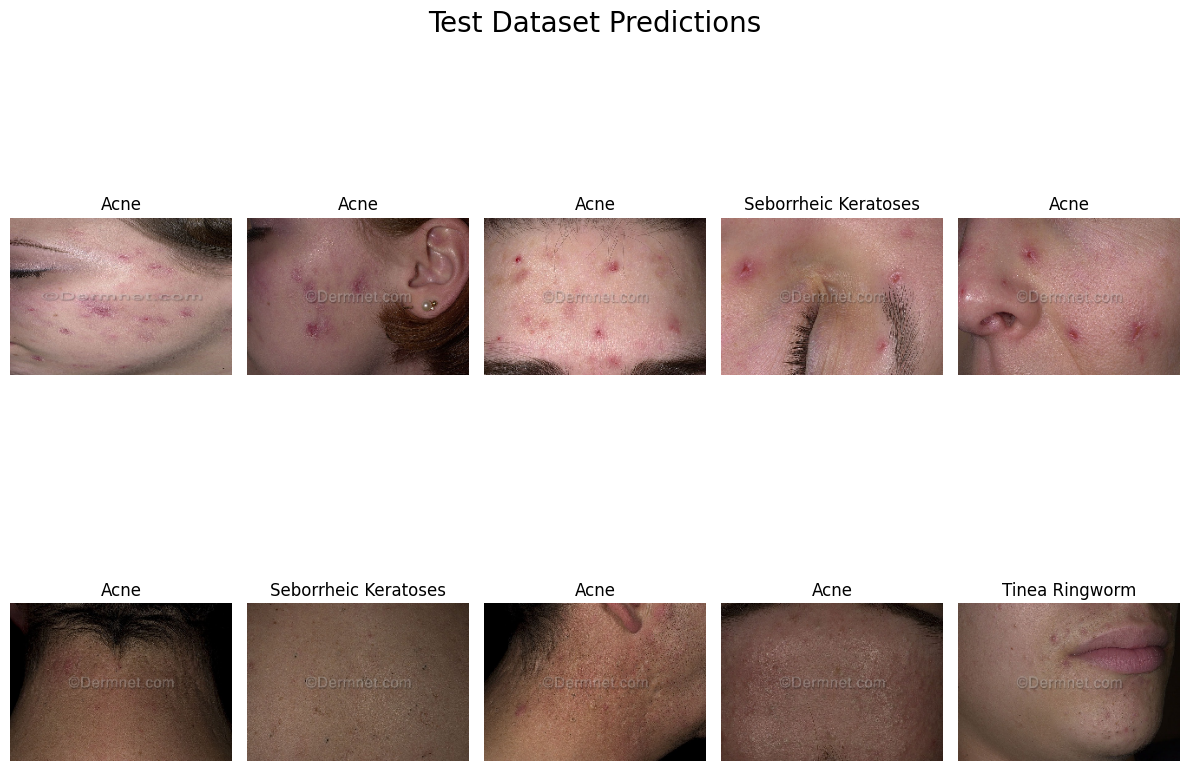

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [45]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

82/82 [==============================] - 55s 674ms/step - loss: 0.5437 - accuracy: 0.8018


ACCURACY

In [46]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.5436806082725525
Test Accuracy: 0.8018397688865662


In [47]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

CONFUSION MATRIX

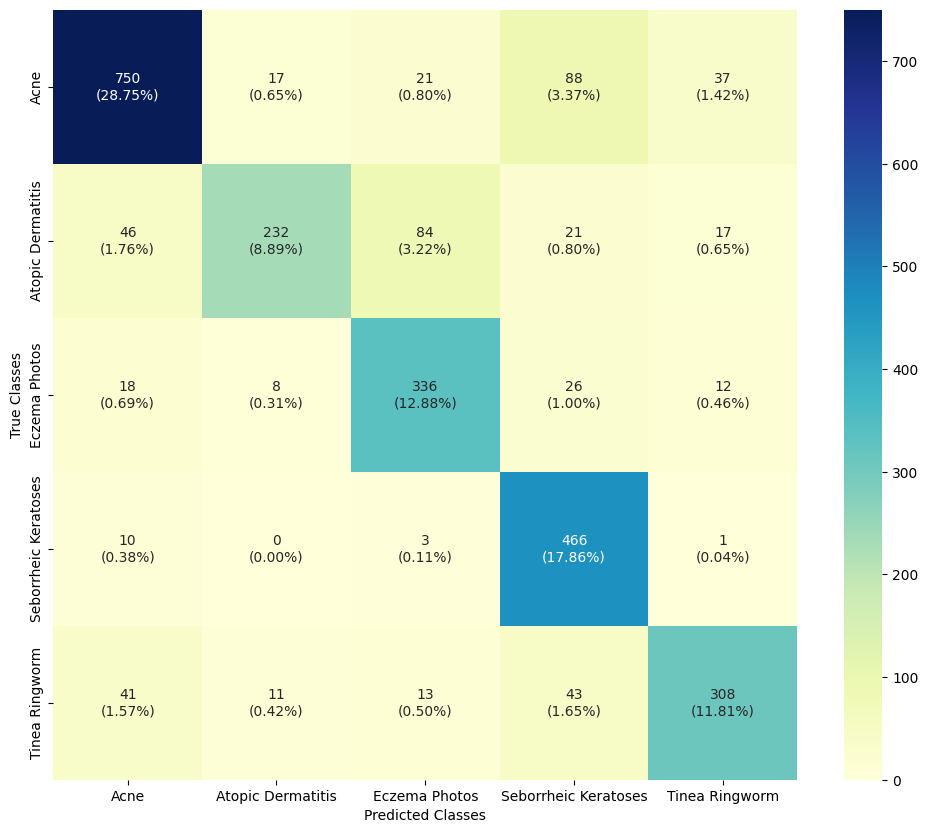

In [49]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [50]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

                      precision    recall  f1-score   support

                Acne       0.87      0.82      0.84       913
   Atopic Dermatitis       0.87      0.58      0.69       400
       Eczema Photos       0.74      0.84      0.78       400
Seborrheic Keratoses       0.72      0.97      0.83       480
      Tinea Ringworm       0.82      0.74      0.78       416

            accuracy                           0.80      2609
           macro avg       0.80      0.79      0.79      2609
        weighted avg       0.81      0.80      0.80      2609



In [51]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [52]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

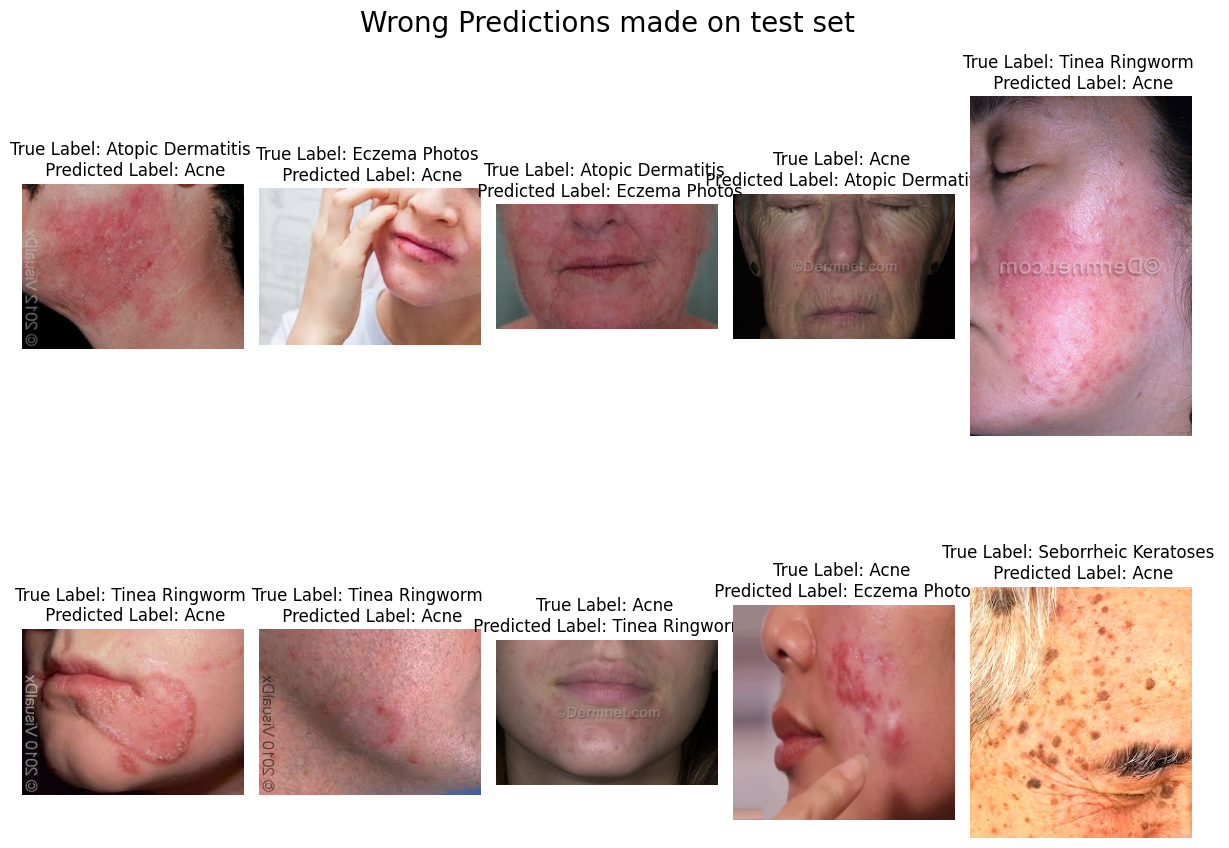

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()                                                                      